# Exercises
1. Classifier for MNIST with over 97% accuracy

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
# from sklearn.datasets import fetch_openml
import joblib

In [2]:
# mnist = fetch_openml("mnist_784", version=1, as_frame=False)
# joblib.dump(mnist, "Chapter 3/mnist.pkl", compress=True)
mnist = joblib.load("Chapter 3/mnist.pkl")

In [3]:
X, y = mnist["data"], mnist["target"]
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [4]:
def plot_digit(digit):
  plt.imshow(digit.reshape(28, 28), cmap="binary")
  plt.axis("off")

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# knn_clf = GridSearchCV(KNeighborsClassifier(), {"n_neighbors": [4, 5, 6], "weights": ["uniform", "distance"]}, cv=3, verbose=4)
# knn_clf.fit(X_train, y_train)

# joblib.dump(knn_clf, "Chapter 3/knn_clf.pkl", compress=True)
knn_clf = joblib.load("Chapter 3/knn_clf.pkl")

In [6]:
knn_clf.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [7]:
knn_clf.best_score_

0.9703500000000002

2. Train the model on an expanded training set consisting of each image in the training set along with four shifted copies (shifted left, right, up, and down)

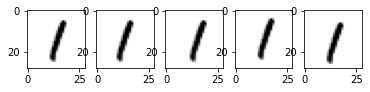

In [8]:
from scipy.ndimage.interpolation import shift

def shift_digit(digit, direction):
  shift_dir_map = {
    "left": [0, -1],
    "right": [0, 1],
    "up": [-1, 0],
    "down": [1, 0],
  }

  shift_dir = shift_dir_map.get(direction) or [0, 0]

  return shift(digit, shift_dir)

def shift_digit_arr(digit, direction):
  return shift_digit(digit.reshape(28, 28), direction).reshape(784)

some_index = 5

for idx, direction in enumerate([None, "left", "right", "up", "down"], start=1):
  plt.subplot(1, 5, idx)
  plot_digit(shift_digit(X_test[some_index].reshape(28, 28), direction))
  plt.axis("on")

In [62]:
directions = [None, "left", "right", "up", "down"]
X_small = X_train
y_small = y_train
# X_train_shifts, y_train_shifts = np.asarray([[shift_digit_arr(x, dir), y] for dir in directions for x, y in zip(X_small, y_small)], dtype=object).T
# X_train_shifts = np.stack(X_train_shifts[:])

['Chapter 3/Xy_train_shifts.pkl']

In [64]:
from sklearn.model_selection import cross_val_score
# cross_val_score(knn_clf.best_estimator_, X_train_shifts, y_train_shifts, cv=3)

array([0.98488, 0.97452, 0.97979])

The above takes a really long time (almost 30 mins on my MacBook Pro) and gives the result: array([0.98488, 0.97452, 0.97979])  
The scores have improved by artificially expanding the data set!

4. Spam classifier

First, merge the spam and ham data into a single labelled dataset  
Should be 2D nparray consisting of the text and a label in $\{0, 1\}$ where $0$ is ham and $1$ is spam

In [2]:
import os

spam_root = "./Chapter 3/Spam Classifier"
# ham_dir = os.path.join(spam_root, "easy_ham")
# spam_dir = os.path.join(spam_root, "spam")

# ham_count = len(os.listdir(path=ham_dir))
# spam_count = len(os.listdir(path=spam_dir))

# data = np.empty((ham_count + spam_count, 2), dtype=np.dtype(object, int))

# for idx, entry in enumerate(os.scandir(ham_dir)):
#   with open(entry.path, 'r', encoding="latin1") as file:
#     data[idx][0] = file.read()
#     data[idx][1] = 0

# for idx, entry in enumerate(os.scandir(spam_dir)):
#   with open(entry.path, 'r', encoding="latin1") as file:
#     data[idx + ham_count][0] = file.read()
#     data[idx + ham_count][1] = 1

data_loc = os.path.join(spam_root, "spam.pkl")
# joblib.dump(data, data_loc, compress=True)
X, y = joblib.load(data_loc).T

Generate a training set and a test set

In [24]:
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train, test in sss.split(X, y):
  X_train = X[train]
  X_test = X[test]
  y_train = y[train].astype(np.int32)
  y_test = y[test].astype(np.int32)

Setup some functions for the data pipeline:
- Convert email to sparse vector
  - Both boolean values and counts
- Strip email headers
- Convert email to lowercase
- Remove punctuation
- Replace URLs with "URL"
- Replace numbers with "NUMBER"
- Replace ips with "IP"
- Use lexemes
- Remove duplicates

In [4]:
import re
from sklearn.base import BaseEstimator, TransformerMixin

class HeaderStripper(TransformerMixin, BaseEstimator):
  def __init__(self, should_strip=True):
    self.should_strip = should_strip

  def __strip_headers(self, content: str):
    content_lines = content.splitlines()
    try:
      headers_end_idx = content_lines.index("") + 1
    except ValueError:
      headers_end_idx = 0
    return "\n".join(content_lines[headers_end_idx:])

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if self.should_strip:
      return np.array([self.__strip_headers(email) for email in X])
    else:
      return X

class CaseConverter(TransformerMixin, BaseEstimator):
  def __init__(self, lower_case=True):
    self.lower_case = lower_case
  
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if self.lower_case:
      return np.array([email.lower() for email in X])
    else:
      return X

class PunctuationRemover(TransformerMixin, BaseEstimator):
  punctuation_re = re.compile(r"[^A-Za-z0-9\s]")

  def __init__(self, remove_punctuation=True):
    self.remove_punctuation = remove_punctuation

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if self.remove_punctuation:
      return np.array([self.punctuation_re.sub("", email) for email in X])
    else:
      return X

class DataReplacer(TransformerMixin, BaseEstimator):
  url_re = re.compile(r"[^\s<>(){}\[\]@=]+\.(?:co\.uk|com|net|org|co|biz|localhost)(?:[/?][^\s<>(){}\[\]@]*)?|localhost", flags=re.IGNORECASE)
  number_re = re.compile(r"\d+")
  ipv4_re = re.compile(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

  def __init__(self, should_replace_urls=True, should_replace_numbers=True, should_replace_ips=True):
    self.should_replace_urls = should_replace_urls
    self.should_replace_numbers = should_replace_numbers
    self.should_replace_ips = should_replace_ips

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    transformed_X = X

    if self.should_replace_ips:
      transformed_X = np.array([self.__replace_ips(email) for email in transformed_X])
    if self.should_replace_urls:
      transformed_X = np.array([self.__replace_urls(email) for email in transformed_X])
    if self.should_replace_numbers:
      transformed_X = np.array([self.__replace_numbers(email) for email in transformed_X])
    
    return transformed_X

  def __replace_urls(self, email: str):
    return "\n".join([self.url_re.sub(" URL ", line) for line in email.splitlines()])

  def __replace_numbers(self, email: str):
    return self.number_re.sub(" NUMBER ", email)

  def __replace_ips(self, email: str):
    return self.ipv4_re.sub(" IP ", email)


In [5]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')

class WordSplitter(TransformerMixin, BaseEstimator):
  ps = PorterStemmer()
  word_sep_re = re.compile(r"[\s]+")

  def __init__(self, get_stems=True):
    self.get_stems = get_stems

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    if not self.get_stems:
      return np.array([self.word_sep_re.split(email) for email in X])

    transformed_X = []
    for email in X:
      words = word_tokenize(email)
      transformed_X.append([self.ps.stem(word) for word in words])

    return np.array(transformed_X, dtype=object)

[nltk_data] Downloading package punkt to /Users/mike/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from scipy.sparse import dok_matrix

# Didn't end up using this, but it *almost* works
# I'm pretty sure the sparse matrix should be able to handle adding the words as keys directly

class WordEncoder(TransformerMixin, BaseEstimator):
  def __init__(self, binary_encoding=False):
    self.binary_encoding = binary_encoding

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    word_dicts = [self.__get_word_dictionary(words) for words in X]
    word_idx_map = self.__get_word_index_map(word_dicts)

    mat = dok_matrix((len(X), len(word_idx_map)), dtype=int)
    for idx, d in enumerate(word_dicts):
      for word in d:
        word_idx = word_idx_map[word]
        mat.setdefault((idx, word_idx), 1 if self.binary_encoding else word_dicts[idx][word])

    return mat

  def __get_word_dictionary(self, words):
    word_dict = {}
    for word in words:
      word_dict[word] = word_dict.setdefault(word, 0) + 1

    return word_dict

  def __get_word_index_map(self, word_dicts):
    unique_words = set()
    for d in word_dicts:
      for word in d:
        unique_words.add(word)

    word_idx_map = {}
    for idx, word in enumerate(unique_words):
      word_idx_map[word] = idx

    return word_idx_map

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_extraction.text import CountVectorizer

pipeline = Pipeline([
  ("header", HeaderStripper(should_strip=True)),
  ("replacer", DataReplacer()),
  ("punctuation", PunctuationRemover()),
  # ("split", WordSplitter()),
  # ("encode", WordEncoder()),
  ("count", CountVectorizer(strip_accents="unicode", lowercase=True)),
  ("clf", RidgeClassifier(random_state=42)),
])

Use GridSearchCV to try different parameters for the pipeline

In [39]:

from sklearn.model_selection import GridSearchCV

# clf = GridSearchCV(pipeline, {
#   "header__should_strip": [True, False],
#   "replacer__should_replace_urls": [True, False],
#   "replacer__should_replace_ips": [True, False],
#   "replacer__should_replace_numbers": [True, False],
#   "punctuation__remove_punctuation": [True, False],
#   "count__binary": [True, False],
#   "clf__alpha": np.linspace(1.0, 3.0, 3)
# }, cv=3, verbose=4, n_jobs=-1, scoring="recall")

# clf.fit(X_train, y_train)

clf_loc = os.path.join(spam_root, "grid_search_fitted.pkl")
# joblib.dump(clf, clf_loc)
clf = joblib.load(clf_loc)

clf.best_params_

{'clf__alpha': 3.0,
 'count__binary': True,
 'header__should_strip': False,
 'punctuation__remove_punctuation': False,
 'replacer__should_replace_ips': False,
 'replacer__should_replace_numbers': False,
 'replacer__should_replace_urls': False}

Test on the test set

In [42]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

y_test_pred = clf.best_estimator_.predict(X_test)

print("precision = ", precision_score(y_test, y_test_pred), ", recall = ", recall_score(y_test, y_test_pred), ", F1 = ", f1_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)

precision =  0.99 , recall =  0.99 , F1 =  0.99


array([[499,   1],
       [  1,  99]])

Only one false positive and one false negative out of 600 emails!